<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
#!conda install -c conda-forge pydotplus python-graphviz -y


In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from matplotlib.ticker import NullFormatter
import pandas as pd
from sklearn import preprocessing
import pylab as pl
import scipy.optimize as opt
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, jaccard_similarity_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO
#import pydotplus # for tree plotting, not necessary for this assignment
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2018-12-14 23:12:32--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2018-12-14 23:12:32 (13.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

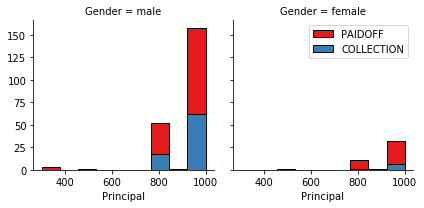

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

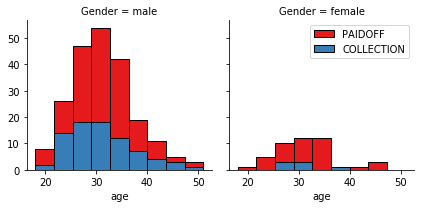

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

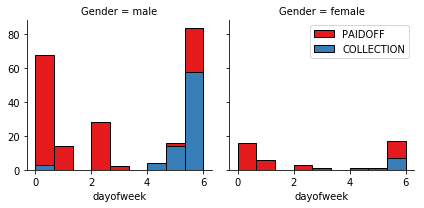

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [21]:
###########
# train-set train-test split for model SELECTION, 
#later the pre-processed test-csv is used for model validation!!!!
###########
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.15, random_state=4)

In [22]:
# test k 1 to 20
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([ 0.67307692,  0.63461538,  0.69230769,  0.67307692,  0.73076923,
        0.71153846,  0.76923077,  0.75      ,  0.78846154,  0.65384615,
        0.67307692,  0.71153846,  0.75      ,  0.69230769,  0.69230769,
        0.71153846,  0.71153846,  0.71153846,  0.71153846])

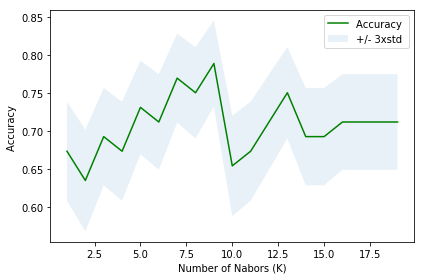

In [23]:
# plot results
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [24]:
print( "The best TRAIN accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best TRAIN accuracy was with 0.788461538462 with k= 9


In [25]:
# Set best performing K measured on the training set with test-train-split.
k=mean_acc.argmax()+1
# Train the KNN-classifier on the WHOLE training set.
neigh = KNeighborsClassifier(n_neighbors = k).fit(X,y)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

# Decision Tree

In [26]:
selected_depth = 240
mean_tree_acc = np.zeros((selected_depth-1))
# not 1,selected_depth, because confusion matrix shows that every prediction is of only one class, then it is based on pure chance or no_model.
for n in range(3,selected_depth): 
    # model definition, fitting, predictions
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    # loanTree # it shows the default parameters
    loanTree.fit(X_train,y_train)
    # train accuracy
    # prediction with train-test-split of Train-set.
    yhat = loanTree.predict(X_test)
    #print("Best DecisionTrees's Accuracy on (train-test-split) with depth: {} and accuracy:{} ".format(n, metrics.accuracy_score(y_test, yhat)) )
    mean_tree_acc[n-1] = metrics.accuracy_score(y_test, yhat)

In [27]:
print('Select best performing depth {}: with accuracy: {} on train set:'.format(mean_tree_acc.argmax()+1,  mean_tree_acc.max() ))
# retrain the tree on the WHOLE train-set
final_selected_depth = mean_tree_acc.argmax()+1
# re fit/train on the whole Train-set
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = final_selected_depth)
loanTree.fit(X,y)

Select best performing depth 6: with accuracy: 0.7884615384615384 on train set:


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [28]:
# tree plotting , not needed.
#dot_data = StringIO()
#filename = "loantree.png"
#featureNames = Feature.columns[:]
#targetNames = df['loan_status'].unique().tolist()
#out=tree.export_graphviz(drugTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png(filename)
#img = mpimg.imread(filename)
#plt.figure(figsize=(100, 200))
#plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
# write your code 
kernels = ['poly','rbf', 'linear', 'sigmoid']
c_values = [1.2,1.15,1.1,1.05,1.0,0.95,0.90,0.85,0.80,0.75,0.7]
mean_svm_acc = []

for kernel in kernels:
    for c_value in c_values:
        clf2 = svm.SVC(C=c_value, kernel=kernel)
        clf2.fit(X_train, y_train) 
        yhat = clf2.predict(X_test)
        # Compute confusion matrix
        #cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
        #np.set_printoptions(precision=2)
        mean_svm_acc.append( [kernel,c_value,jaccard_similarity_score(y_test, yhat), f1_score(y_test, yhat, average='weighted')] )

meandf = pd.DataFrame(mean_svm_acc, columns=['Algorithm','C_value','Jaccard','F1-score']) 
#meandf      

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
# select kernel, c_value on best f1-score
best_kernel = meandf.loc[meandf['F1-score'].idxmax()][0]
best_c_value = meandf.loc[meandf['F1-score'].idxmax()][1]
print('the best kernel = {}, and the best performing c_value with {} is: {}'.format(best_kernel,best_kernel,best_c_value))
# train with full training set, instead of train-set-test/trainsplit
clf = svm.SVC(C=best_c_value, kernel=best_kernel)
clf.fit(X,y)

the best kernel = rbf, and the best performing c_value with rbf is: 1.2


SVC(C=1.2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Logistic Regression

In [32]:
kernels = [ 'liblinear'] #'lbfgs','newton-cg','sag',  'saga' in conf_matrix only 1 class predicted
c_values = [1.3,1.0,0.6,0.3,0.1,0.06,0.03,0.01,0.006,0.003,0.001]
mean_log_acc = []

for kernel in kernels:
    for c_value in c_values:
    # write your code here lbfgs liblinear newton-cg sag
        LR2 = LogisticRegression(C=c_value, solver=kernel, random_state=44, max_iter=400).fit(X_train,y_train)
        #LR2
        yhat = LR2.predict(X_test)
        yhat_prob = LR2.predict_proba(X_test)
        mean_log_acc.append( [kernel,c_value,jaccard_similarity_score(y_test, yhat), f1_score(y_test, yhat, average='weighted'), log_loss(y_test, yhat_prob)] )
mean_log_df = pd.DataFrame(mean_log_acc, columns=['Algorithm','C_value','Jaccard','F1-score','log_loss'])
mean_log_df

,Algorithm,C_value,Jaccard,F1-score,log_loss
0,liblinear,1.300,0.769231,0.745629,0.508643
1,liblinear,1.000,0.769231,0.745629,0.507751
2,liblinear,0.600,0.769231,0.745629,0.506104
3,liblinear,0.300,0.769231,0.745629,0.504941
4,liblinear,0.100,0.769231,0.745629,0.510435
5,liblinear,0.060,0.769231,0.745629,0.518537
6,liblinear,0.030,0.769231,0.745629,0.537444
7,liblinear,0.010,0.711538,0.705644,0.585275
8,liblinear,0.006,0.673077,0.688344,0.610636
9,liblinear,0.003,0.653846,0.674038,0.641215


In [33]:
# select kernel, c_value on best f1-score
best_kernel = mean_log_df.loc[mean_log_df['F1-score'].idxmax()][0]
best_f1 = mean_log_df.loc[mean_log_df['F1-score'].idxmax()][3]

tempdf = mean_log_df.loc[(mean_log_df['F1-score'] == best_f1)]

best_c_value = tempdf.loc[tempdf['log_loss'].idxmax()][1]

print('the best kernel = {}, and the best performing c_value with {} is: {}'.format(best_kernel,best_kernel,best_c_value))
# train with full training set, instead of train-set-test/trainsplit
LR = LogisticRegression(C=best_c_value, solver=best_kernel, random_state=44, max_iter=400).fit(X,y)
LR.fit(X,y)
# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')
#print (classification_report(y_test, yhat))
#log_loss(y_test, yhat_prob)
# Jaccard similarity
#print(jaccard_similarity_score(y_test, yhat) )
#print(f1_score(y_test, yhat, average='weighted') )


the best kernel = liblinear, and the best performing c_value with liblinear is: 0.03


LogisticRegression(C=0.029999999999999999, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=400,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=44,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# Model Evaluation using Test set

In [34]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
report_df = pd.DataFrame(columns=['Algorithm','Jaccard','F1-score','LogLoss'])
#report_df


First, download and load the test set:

In [35]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2018-12-14 23:12:35--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2018-12-14 23:12:35 (616 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [36]:
test_df = pd.read_csv('loan_test.csv')
# date-time transformations
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
# reapply train data transformations
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
FeatureT = test_df[['Principal','terms','age','Gender','weekend']]
FeatureT = pd.concat([FeatureT,pd.get_dummies(test_df['education'])], axis=1)
FeatureT.drop(['Master or Above'], axis = 1,inplace=True)
# test features
XX_test = FeatureT
yy_test = test_df['loan_status'].values
# Standarisation of X_test
XX_test= preprocessing.StandardScaler().fit(XX_test).transform(XX_test)

#FeatureT.head()
#test_df.head()
XX_test[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [37]:
# knn eval
yhat=neigh.predict(XX_test)
print (classification_report(yy_test, yhat))
# Compute confusion matrix
cnf_matrix = confusion_matrix(yy_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)
print('{} ==confusion matrix '.format(cnf_matrix))
report_df.loc[0] = ['KNN',(jaccard_similarity_score(yy_test, yhat)),(f1_score(yy_test, yhat, average='weighted')),'NA']
report_df.loc[0]

             precision    recall  f1-score   support

 COLLECTION       0.38      0.21      0.27        14
    PAIDOFF       0.76      0.88      0.81        40

avg / total       0.66      0.70      0.67        54

[[35  5]
 [11  3]] ==confusion matrix 


Algorithm         KNN
Jaccard      0.703704
F1-score     0.673636
LogLoss            NA
Name: 0, dtype: object

In [38]:
predTree = loanTree.predict(XX_test)
print (classification_report(yy_test, predTree))
# Compute confusion matrix
cnf_matrix = confusion_matrix(yy_test, predTree, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)
print('{} ==confusion matrix '.format(cnf_matrix))
report_df.loc[1] = ['Decision Tree',(jaccard_similarity_score(yy_test, predTree)),(f1_score(yy_test, predTree, average='weighted')),'NA']
report_df.loc[1]

             precision    recall  f1-score   support

 COLLECTION       0.50      0.21      0.30        14
    PAIDOFF       0.77      0.93      0.84        40

avg / total       0.70      0.74      0.70        54

[[37  3]
 [11  3]] ==confusion matrix 


Algorithm    Decision Tree
Jaccard           0.740741
F1-score          0.700673
LogLoss                 NA
Name: 1, dtype: object

In [39]:
yhat = clf.predict(XX_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(yy_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)
print (classification_report(yy_test, yhat))
print('{} ==confusion matrix '.format(cnf_matrix))
report_df.loc[2] = ['SVM',(jaccard_similarity_score(yy_test, yhat)),(f1_score(yy_test, yhat, average='weighted')),'NA']
report_df.loc[2]

             precision    recall  f1-score   support

 COLLECTION       0.00      0.00      0.00        14
    PAIDOFF       0.74      0.97      0.84        40

avg / total       0.55      0.72      0.62        54

[[39  1]
 [14  0]] ==confusion matrix 


Algorithm         SVM
Jaccard      0.722222
F1-score     0.621266
LogLoss            NA
Name: 2, dtype: object

In [40]:
yyhat = LR2.predict(XX_test)
yyhat_prob = LR2.predict_proba(XX_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(yy_test, yyhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)
print (classification_report(yy_test, yyhat))
print('{} ==confusion matrix '.format(cnf_matrix))
report_df.loc[3] = ['LogisticRegression',(jaccard_similarity_score(yy_test, yyhat)),(f1_score(yy_test, yyhat, average='weighted')),(log_loss(yy_test, yyhat_prob))]
report_df.loc[3]

             precision    recall  f1-score   support

 COLLECTION       0.40      0.14      0.21        14
    PAIDOFF       0.76      0.93      0.83        40

avg / total       0.66      0.72      0.67        54

[[37  3]
 [12  2]] ==confusion matrix 


Algorithm    LogisticRegression
Jaccard                0.722222
F1-score               0.670478
LogLoss                 0.66807
Name: 3, dtype: object

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

In [41]:
report_df

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.703704,0.673636,NA
1,Decision Tree,0.740741,0.700673,NA
2,SVM,0.722222,0.621266,NA
3,LogisticRegression,0.722222,0.670478,0.66807


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>